In [1]:
#Python
import numpy as np
import configparser
from matplotlib import pyplot as plt
#Keras
from keras.models import model_from_json
from keras.models import Model
#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
import sys
sys.path.insert(0, '../lib/')
# help_functions.py
from help_functions import *
# extract_patches.py
from extract_patches import recompone
from extract_patches import recompone_overlap
from extract_patches import paint_border
from extract_patches import kill_border
from extract_patches import pred_only_FOV
from extract_patches import get_data_testing
from extract_patches import get_data_testing_overlap
# pre_processing.py
from pre_processing import my_PreProc

Using TensorFlow backend.


# Read config file

In [2]:
#========= CONFIG FILE TO READ FROM =======
config = configparser.RawConfigParser()
config.read('configuration.txt')

['configuration.txt']

In [3]:
#===========================================
#run the training on invariant or local
path_data = config.get('data paths', 'path_local')

#original test images (for FOV selection)
DRIVE_test_imgs_original = path_data + config.get('data paths', 'test_imgs_original')
test_imgs_orig = load_hdf5(DRIVE_test_imgs_original)
full_img_height = test_imgs_orig.shape[2]
full_img_width = test_imgs_orig.shape[3]
#the border masks provided by the DRIVE
DRIVE_test_border_masks = path_data + config.get('data paths', 'test_border_masks')
test_border_masks = load_hdf5(DRIVE_test_border_masks)
# dimension of the patches
patch_height = int(config.get('data attributes', 'patch_height'))
patch_width = int(config.get('data attributes', 'patch_width'))
#the stride in case output with average
stride_height = int(config.get('testing settings', 'stride_height'))
stride_width = int(config.get('testing settings', 'stride_width'))
assert (stride_height < patch_height and stride_width < patch_width)
#model name
name_experiment = config.get('experiment name', 'name')
path_experiment = './' +name_experiment +'/'
#N full images to be predicted
Imgs_to_test = int(config.get('testing settings', 'full_images_to_test'))
#Grouping of the predicted images
N_visual = int(config.get('testing settings', 'N_group_visual'))
#====== average mode ===========
average_mode = config.getboolean('testing settings', 'average_mode')

In [4]:
#ground truth
gtruth= path_data + config.get('data paths', 'test_groundTruth')
img_truth= load_hdf5(gtruth)
# visualize(group_images(test_imgs_orig[0:20,:,:,:],5),'original')#.show()
# visualize(group_images(test_border_masks[0:20,:,:,:],5),'borders')#.show()
# visualize(group_images(img_truth[0:20,:,:,:],5),'gtruth')#.show()

# Load the data and divide in patches

In [5]:
#============ Load the data and divide in patches
patches_imgs_test = None
new_height = None
new_width = None
masks_test  = None
patches_masks_test = None
if average_mode == True:
    patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
        DRIVE_test_imgs_original=DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth=path_data + config.get('data paths', 'test_groundTruth'),  #masks
        Imgs_to_test=int(config.get('testing settings', 'full_images_to_test')),
        patch_height=patch_height,
        patch_width=patch_width,
        stride_height=stride_height,
        stride_width=stride_width
    )
else:
    patches_imgs_test, patches_masks_test = get_data_testing(
        DRIVE_test_imgs_original=DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth=path_data + config.get('data paths', 'test_groundTruth'),  #masks
        Imgs_to_test=int(config.get('testing settings', 'full_images_to_test')),
        patch_height=patch_height,
        patch_width=patch_width,
    )


the side H is not compatible with the selected stride of 5
img_h 584, patch_h 48, stride_h 5
(img_h - patch_h) MOD stride_h: 1
So the H dim will be padded with additional 4 pixels
the side W is not compatible with the selected stride of 5
img_w 565, patch_w 48, stride_w 5
(img_w - patch_w) MOD stride_w: 2
So the W dim will be padded with additional 3 pixels
new full images shape: 
(20, 1, 588, 568)

test images shape:
(20, 1, 588, 568)

test mask shape:
(20, 1, 584, 565)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

Number of patches on h : 109
Number of patches on w : 105
number of patches per image: 11445, totally for this dataset: 228900

test PATCHES images shape:
(228900, 1, 48, 48)
test PATCHES images range (min-max): 0.0 - 1.0


# Run the prediction of the patches

In [6]:
#================ Run the prediction of the patches ==================================
best_last = config.get('testing settings', 'best_last')
#Load the saved model
model = model_from_json(open(path_experiment+name_experiment +'_architecture.json').read())
model.load_weights(path_experiment+name_experiment + '_'+best_last+'_weights.h5')











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [7]:
#Calculate the predictions
predictions = model.predict(patches_imgs_test, batch_size=32, verbose=2)
print("predicted images size :")
print(predictions.shape)

predicted images size :
(228900, 2304, 2)


In [8]:
#===== Convert the prediction arrays in corresponding images
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "original")

# Elaborate and visualize the predicted images

In [9]:
#========== Elaborate and visualize the predicted images ====================
pred_imgs = None
orig_imgs = None
gtruth_masks = None
if average_mode == True:
    pred_imgs = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
    orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = masks_test  #ground truth masks
else:
    pred_imgs = recompone(pred_patches,13,12)       # predictions
    orig_imgs = recompone(patches_imgs_test,13,12)  # originals
    gtruth_masks = recompone(patches_masks_test,13,12)  #masks

N_patches_h: 109
N_patches_w: 105
N_patches_img: 11445
According to the dimension inserted, there are 20 full images (of 588x568 each)
(20, 1, 588, 568)


In [10]:
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print("Orig imgs shape: " +str(orig_imgs.shape))
print("pred imgs shape: " +str(pred_imgs.shape))
print("Gtruth imgs shape: " +str(gtruth_masks.shape))

Orig imgs shape: (20, 1, 584, 565)
pred imgs shape: (20, 1, 584, 565)
Gtruth imgs shape: (20, 1, 584, 565)


In [2]:
# visualize(group_images(orig_imgs,N_visual),path_experiment+"all_originals")#.show()

In [3]:
# visualize(group_images(pred_imgs,N_visual),path_experiment+"all_predictions")#.show()

In [4]:
# visualize(group_images(gtruth_masks,N_visual),path_experiment+"all_groundTruths")#.show()

In [14]:
#visualize results comparing mask and prediction:
assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
    total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    visualize(total_img,path_experiment+name_experiment +"_Original_GroundTruth_Prediction"+str(i))#.show()

In [15]:
#====== Evaluate the results
print("\n\n=======================  Evaluate the results =======================")
#predictions only inside the FOV
y_scores, y_true = pred_only_FOV(pred_imgs,gtruth_masks, test_border_masks)  #returns data only inside the FOV
print("Calculating results only inside the FOV:")
print("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")



=======================  Evaluate the results =======================
Calculating results only inside the FOV:
y scores pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)
y true pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)



Area under the ROC curve: 0.9766588810800494


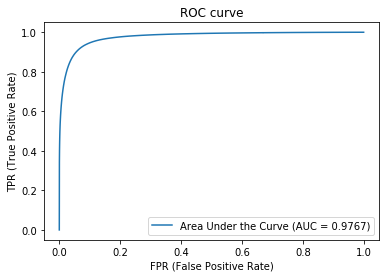

In [16]:
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"ROC.png")


Area under Precision-Recall curve: 0.902325313922855


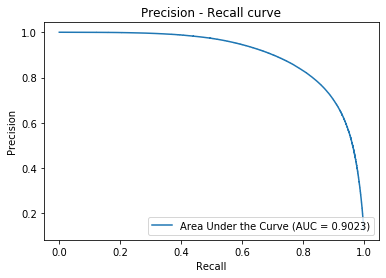

In [17]:
#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"Precision_recall.png")

In [18]:
#Confusion matrix
threshold_confusion = 0.5
print("\nConfusion matrix:  Costum threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print(confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print("Precision: " +str(precision))

#Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print("\nF1 score (F-measure): " +str(F1_score))


Confusion matrix:  Costum threshold (for positive) of 0.5
[[3896602   63892]
 [ 144979  432670]]
Global Accuracy: 0.9539743458943449
Specificity: 0.9838676690332064
Sensitivity: 0.7490188678592017
Precision: 0.8713312738389164


/home/user02/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)



Jaccard similarity score: 0.9539743458943449

F1 score (F-measure): 0.8055586844670182


In [19]:
#Save the results
file_perf = open(path_experiment+'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()